In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import nibabel as nib

from nistats import design_matrix as dm
from bids.layout import BIDSLayout
from scipy.signal import convolve, resample
from nistats import hemodynamic_models
from nistats.first_level_model import FirstLevelModel
from nistats.design_matrix import make_first_level_design_matrix
from nistats.reporting import plot_design_matrix
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/duecredit/io.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import defaultdict, Iterator
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_val

In [2]:
# borrowed from:
# https://github.com/achennings/python_deconvolution/blob/master/deconvolve.ipynb?fbclid=IwAR1bpNjAcxZ9x24oZiwsZE_Rcjg-FLuUp1zoJ7vmS_lZCBti-0ITkCJ0RG8
# https://github.com/kbonna/decidenet/blob/master/connectivity_analysis/dn_ca_01_ridge_deconvolution.ipynb
def dct_basis(n, k):
    '''Creates basis functions for Discrete Cosine Transform (DCT).
    
    Args:
        n (int): Number of signal timepoints.
        k (int): Number of basis functions.
        
    Returns:
        Discrete cosine basis set in a matrix form. Shape of the matrix is n x k.
    '''
    X = np.zeros((n, k))
    for i in range(k):
        X[:, i] = np.sqrt(2 / n) * np.cos(np.pi * np.arange(n) * i / n)
    return X


def deconvolve(signal, alpha, X, HX):
    '''Deconvolve signal using ridge regression and cosine basis set.
    
    Uses ridge regression for solving set of correlated linear equations. Ridge regression allows 
    solving matrix equation y=Xb+e introducing regularization parameter. X corresponds to chosen
    basis set (here cosine set convolved with HRF), b is a vector of unknown weights for basis 
    functions and y is modeled signal. Fitted b weights are used to recreate neural signal as linear
    combinations of unconvolved cosines.
    
    Args:
        signal (iterable):
            BOLD signal.
        alpha (float):
            Regularization parameter (lower-bounded by zero).
        X (2-D array):
            Basis functions in neural space (not convolved).
        HX (2-D array):
            Basis functions in BOLD space (convolved with HRF).
        
    Returns:
        Deconvolved BOLD signal in neural space.
    '''
    lin = Ridge(
        alpha=alpha,
        solver='lsqr',
        fit_intercept=False,
        normalize=False,
        max_iter=1000
    )
    lin.fit(HX, signal)
    return np.matmul(X, lin.coef_)


def _select_confounds(confounds_file, selected_confounds):
    """Process and return selected confounds from the confounds file
    Parameters
    ----------
    confounds_file : str
        File that contains all usable confounds
    selected_confounds : list
        List containing all desired confounds.
        confounds can be listed as regular expressions (e.g., "motion_outlier.*")
    Returns
    -------
    desired_confounds : DataFrame
        contains all desired (processed) confounds.
    """
    import pandas as pd
    import numpy as np
    import re

    confounds_df = pd.read_csv(confounds_file, sep='\t', na_values='n/a')
    # regular expression to capture confounds specified at the command line
    confound_expr = re.compile(r"|".join(selected_confounds))
    expanded_confounds = list(filter(confound_expr.fullmatch, confounds_df.columns))
    imputables = ('framewise_displacement', 'std_dvars', 'dvars', '.*derivative1.*')

    # regular expression to capture all imputable confounds
    impute_expr = re.compile(r"|".join(imputables))
    expanded_imputables = list(filter(impute_expr.fullmatch, expanded_confounds))
    for imputable in expanded_imputables:
        vals = confounds_df[imputable].values
        if not np.isnan(vals[0]):
            continue
        # Impute the mean non-zero, non-NaN value
        confounds_df[imputable][0] = np.nanmean(vals[vals != 0])

    desired_confounds = confounds_df[expanded_confounds]
    # check to see if there are any remaining nans
    if desired_confounds.isna().values.any():
        msg = "The selected confounds contain nans: {conf}".format(conf=expanded_confounds)
        raise ValueError(msg)
    return desired_confounds


def get_duplicate_columns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if np.all(np.isclose(col, otherCol)):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)


def convolve_signal(signal, t_r=2, oversampling=50, hrf_model='spm'):
    '''Convolve signal with hemodynamic response function.
    
    Performs signal convolution with requested hrf model. This function wraps around nistats 
    compute_regressor function usually used for creating task-based regressors. The trick is to 
    define neural regressor as a sequence of equally spaced (with the gap of 1TR) and modulated
    'task events'. Event amplitude modulation corresponds to neural signal amplitude at a given 
    timepoint.
    
    Args:
        signal (iterable):
            Neural signal.
        t_r (float):
            Repetition time in seconds.
        oversampling (int, optional):
            Convolution upsampling rate.
        hrf_model (str, optional):
            Hemodynamic response function type. See the documentation of compute regressor function 
            from nistats.hemodynamic_models for more details.
            
    Returns:
        Convolved neural signal in BOLD space.
    '''
    n_volumes = len(signal)
    frame_times = np.arange(0, n_volumes * t_r, t_r)
    onsets = np.zeros((3, n_volumes))
    for vol, amplitude in enumerate(signal):
        onsets[:, vol] = (vol * t_r, 0, amplitude)

    signal_bold = hemodynamic_models.compute_regressor(
        onsets,
        hrf_model=hrf_model,                              
        frame_times=frame_times,
        oversampling=oversampling,     
        fir_delays=None)[0].ravel()

    return signal_bold

In [3]:
# Hardcoded PATHS
BIDS_PATH = '../..'
FMRIPREP_PATH = '../fmriprep'
# DATABASE_PATH = '/home/jdkent/first_level.sqlite'
# DATABASE_PATH = '/home/jdkent/'
FIRST_LEVEL_RESULTS = './outputs/first_level_res.pkl'
SECOND_LEVEL_RESULTS = './outputs/second_level_res.pkl'
# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# OUTPUTS
ATLAS_PATH = '../data/overall_response_atlas.nii.gz'
ATLAS_LUT = '../data/overall_response.tsv'
SCHAEFER_PATH = '../data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.nii.gz' 
SCHAEFER_LUT = '../data/schaefer_parcel-400_network-17.tsv'

In [15]:
# layout to get the necessary data files
layout = BIDSLayout(BIDS_PATH,
                    derivatives=FMRIPREP_PATH,
                    # database_path=DATABASE_PATH,
                    #reset_database=False
)

## Filter data based on Framewise Displacement


In [5]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

,bids_name,aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,...,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr,task,participant_id
0,sub-GE120001_ses-pre_task-fauxbold_bold,0.001063,0.006351,2,16.187316,1.198663,1.010760,0.448331,3009467.75,0.103818,...,232.520432,1381.902222,1410.488159,29195.0,837.753119,1812.366785,297.530945,64.075073,fauxbold,GE120001
3,sub-GE120001_ses-pre_task-taskswitch_bold,0.003942,0.005572,2,15.734272,1.148948,0.957532,0.450887,1364181.25,0.138379,...,216.930939,1391.725708,1421.432861,29084.0,868.629898,1788.999225,284.924835,72.902779,taskswitch,GE120001
4,sub-GE120002_ses-pre_task-fauxbold_bold,0.002056,0.010868,1,17.975215,1.024274,1.143355,0.432753,3026978.75,0.227028,...,225.343140,1283.572998,1322.169800,27338.0,738.498715,1686.504254,287.157501,47.578674,fauxbold,GE120002
7,sub-GE120002_ses-pre_task-taskswitch_bold,0.002134,0.004827,1,16.918552,1.176876,0.990735,0.431836,4213331.00,0.169619,...,229.552505,1292.104004,1334.634033,27340.0,734.595834,1700.930396,292.718201,71.898445,taskswitch,GE120002
8,sub-GE120003_ses-pre_task-fauxbold_bold,0.003094,0.018135,1,38.223070,1.116687,0.909317,0.393451,2381240.50,0.577373,...,246.342178,1247.227295,1309.490601,23125.0,595.968738,1648.415723,314.057434,31.255548,fauxbold,GE120003


In [6]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]

In [7]:
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [8]:
ent = layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

In [9]:
participant = layout.get_subjects()[0]
task = 'taskswitch'

In [11]:
preproc = layout.get(subject=participant,
                 suffix='bold',
                 extension='nii.gz',
                 desc='preproc',
                 space='MNI152NLin2009cAsym',
                 task=task)[0]

confounds_file = layout.get(subject=participant,
                            suffix='regressors',
                            extension='tsv',
                            desc='confounds',
                            task=task,
                            return_type='file')[0]

event_file = layout.get(subject=participant,
                            suffix='events',
                            extension='tsv',
                            task=task,
                            return_type='file')[0]

mask_file = layout.get(suffix='mask',
                        extension='nii.gz',
                        desc='brain',
                        space='MNI152NLin2009cAsym',
                        task=task,
                        subject=participant,
                        return_type='file')[0]

In [7]:
masker = NiftiLabelsMasker(ATLAS_PATH)

In [8]:
# remove all confounds from the timeseries.
confounds = [
    "white_matter",
    "csf",
    "cosine[0-9]{2}",
    "framewise_displacement",
    "non_steady_state_outlier[0-9]{2}",
    "motion_outlier[0-9]{2}"
]
confounds_df = _select_confounds(confounds_file, confounds)
test_ts = masker.fit_transform(preproc.path, confounds=confounds_df.values)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict


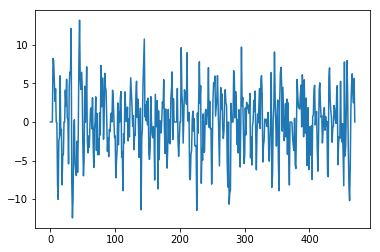

In [9]:
plt.plot(test_ts[:,5])

In [10]:
# create events time series in upsampled space (for the single condition)
events_df = pd.read_csv(event_file, sep='\t')

In [11]:
tr = preproc.get_metadata()['RepetitionTime']


# stim_length = events_df.query("trial_type == 'single'")["duration"].mean()
# onsets = events_df.query("trial_type == 'single'")['onset']

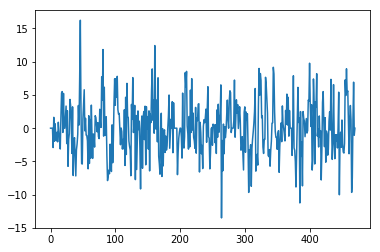

In [12]:
plt.plot(test_ts[:,0])

In [13]:
xb = dct_basis(test_ts.shape[0], test_ts.shape[0])

In [14]:
# 
upsample_factor = 10
hrf = np.array(hemodynamic_models._gamma_difference_hrf(tr=(tr / upsample_factor), oversampling=1))
Hxb = np.zeros((test_ts.shape[0], test_ts.shape[0]))
for i in range(test_ts.shape[0]):
    Hx = convolve(xb[:,i], hrf)[:test_ts.shape[0]]
    Hxb[:,i] = Hx
    

HXb2 = np.zeros(xb.shape)
for i, xi in enumerate(xb):
    HXb2[:, i] = convolve_signal(xi)

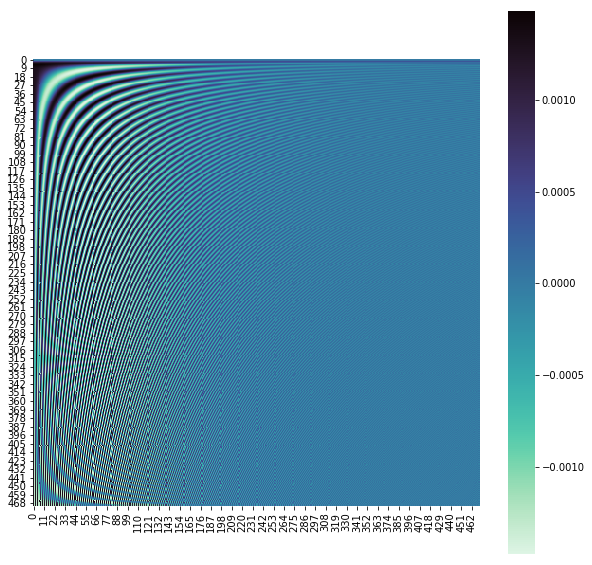

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(HXb2,cmap='mako_r', square=True);

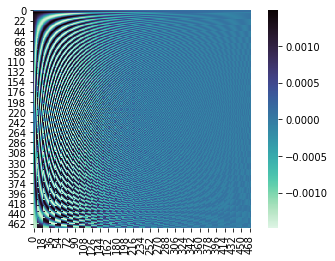

In [16]:
sns.heatmap(HXb2, cmap='mako_r', square=True);

In [17]:
regen = convolve_signal(deconvolve(test_ts[:,0], 0.0001, xb, HXb2))

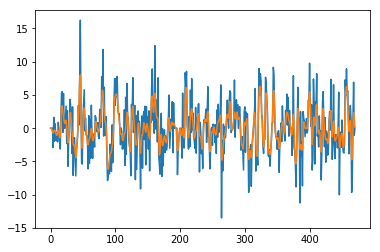

In [18]:
plt.plot(range(test_ts.shape[0]), test_ts[:,0])
plt.plot(range(test_ts.shape[0]), regen)

# looks reasonable

In [19]:
# deconvolve to generate ppi
deconvolved_signal = deconvolve(test_ts[:,0], 0.0001, xb, HXb2)

In [20]:
preproc_file = preproc.path
total_length_seconds = nib.load(preproc_file).shape[-1] * tr


frame_times = np.linspace(0, total_length_seconds, total_length_seconds * upsample_factor)

decon_signal_upsample = resample(deconvolved_signal, total_length_seconds * upsample_factor)

stim_length = events_df.query("trial_type == 'single'")["duration"].mean()
onsets = events_df.query("trial_type == 'single'")['onset']

In [21]:
decon_signal_upsample.shape

(9420,)

In [22]:
stim_length = int(events_df.query("trial_type == 'single'")["duration"].mean() * upsample_factor)
onsets = events_df.query("trial_type == 'single'")['onset'] * upsample_factor
onsets = onsets.astype(int)

In [23]:
upsampled_events = np.zeros(len(frame_times))

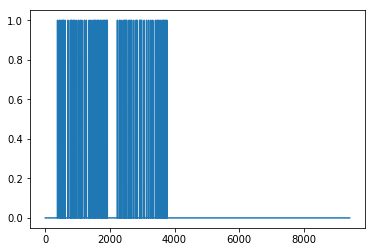

In [24]:
upsampled_events[onsets.values] = 1
plt.plot(upsampled_events)

In [25]:
upsampled_events_convolve = convolve(upsampled_events, np.ones(stim_length), mode='same')

In [26]:
stim_length

15

In [27]:
(upsampled_events_convolve == 1).sum()

590

In [28]:
(upsampled_events == 1).sum()

60

In [29]:
# demean deconvolved signal
decon_signal_upsample_demean = decon_signal_upsample - decon_signal_upsample.mean()

In [30]:
upsampled_events_convolve_demean = upsampled_events_convolve - upsampled_events_convolve.mean()

In [31]:
upsampled_events_convolve_demean

array([-0.0955414, -0.0955414, -0.0955414, ..., -0.0955414, -0.0955414,
       -0.0955414])

In [32]:
# create ppi in neural signal
ppi_neural = decon_signal_upsample_demean * upsampled_events_convolve_demean

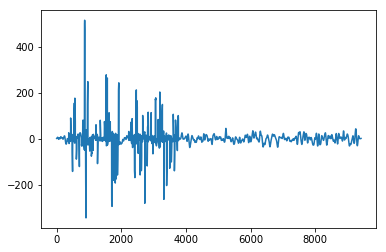

In [33]:
plt.plot(ppi_neural)

In [34]:
# downsample data
ppi_neural_downsample = resample(ppi_neural, test_ts.shape[0])

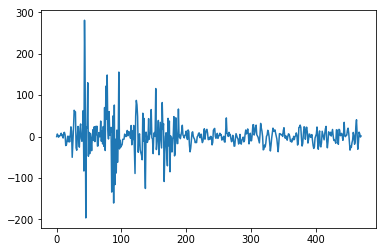

In [35]:
plt.plot(ppi_neural_downsample)

In [36]:
ppi_single = convolve_signal(ppi_neural_downsample)

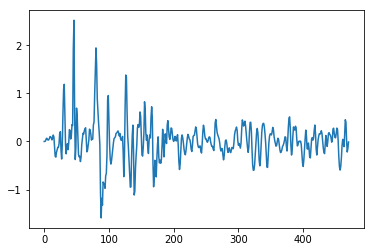

In [37]:
plt.plot(ppi_single)

In [38]:
# afni deconvolve command: 3dTfitter -RHS Seed_ts${cc}${sd}.1D -FALTUNG GammaHR.1D
# spm deconvolve

ppi model components:
- physio signal (cleaned)
- psychological variables (each one gets it's own entry)
- PPI for each condition
- model for task switch
- confounds

$y = \beta_0 + \beta_1single + \beta_2repeat + \beta_3switch + \beta_4firsttrial + \beta_5physio + \beta_6ppi(single) + \beta_7ppi(repeat) + \beta_8ppi(switch) + \beta_nconfounds$

contrasts
- $\beta_8ppi(switch) - \beta_6ppi(single)$
- $\beta_8ppi(switch) - \beta_7ppi(repeat)$
- $\beta_7ppi(repeat) - \beta_6ppi(single)$


to generate each ppi, do each of the following steps:

- extract/clean physio(BOLD) signal
- create basis set
- choose hemodynamic response function (HRF)
- convolve basis set with HRF
- deconvolve physio(BOLD) signal to create neural signal
- upsample neural signal
- demean neural signal
- upsample event onsets (psychological variable)
- demean psychological variable
- multiply demeaned psychological variable and demeaned neural signal creating neural ppi
- downsample neural ppi
- convolve neural ppi to generate bold ppi

In [10]:
def create_ppi(bold, tr, events_df, trial_type=None):
    """
    inputs
    ------
    bold: numpy.array
        numpy array containing bold signal from region of interest
    tr: float
        time of repetition for the BOLD image
    events_df: pandas.DataFrame
        BIDS specified dataframe with columns "onset" and "trial_type"
    trial_type: str or None
        trial type you wish to make a ppi out of. (Otherwise just deconvolve/reconvolve neural signal)
    
    returns
    -------
    ppi: numpy.array
        numpy array representing the psycho-physiological interaction
    
    """
    bold_len = len(bold)
    # create basis set
    xb = dct_basis(bold_len, bold_len)
    
    # convolve basis set with hemodynamic reponse function
    hxb = np.zeros(xb.shape)
    for i, xi in enumerate(xb):
        hxb[:, i] = convolve_signal(xi, t_r=tr)
    
    # deconvolve bold
    neural_signal = deconvolve(bold, 0.0001, xb, hxb)

    # upsample neural signal to be in units of 0.1 seconds
    upsample_factor = int(tr / 0.1)
    upsample_length = int(upsample_factor * bold_len)
    neural_signal_upsample = resample(neural_signal, upsample_length)
    
    # demean neural signal
    neural_signal_demean = neural_signal_upsample - neural_signal_upsample.mean()
    
    # create upsampled psychological variable
    if trial_type is not None:
        # assume mean of stimulus length is "good enough"
        tt_query = "trial_type == '{tt}'".format(tt=trial_type)
        stimulus_duration = int(events_df.query(tt_query)["duration"].mean() * int(upsample_factor/tr))
        onsets = (events_df.query(tt_query)['onset'] * int(upsample_factor/tr)).astype(int)
        psycho_upsample = np.zeros(upsample_length)
        psycho_upsample[onsets.values] = 1
        psycho_convolve = convolve(psycho_upsample, np.ones(stimulus_duration), mode='same')
        psycho_demean = psycho_convolve - psycho_convolve.mean()
    else:
        # dummy variable of ones
        psycho_demean = np.ones(neural_signal_upsample.shape)
    
    # create ppi at neural level
    neural_ppi_upsample = psycho_demean * neural_signal_upsample
    
    # place neural ppi in original bold timescale
    neural_ppi = resample(neural_ppi_upsample, bold_len)
    
    # create ppi for use in model
    ppi = convolve_signal(neural_ppi)
    
    return ppi

## create ppi model



In [84]:
ppis = {tt+"_ppi": create_ppi(test_ts[:, 0], 2, events_df, tt) for tt in ['single', 'repeat', 'switch']}
ppis['physio'] = test_ts[:, 0]

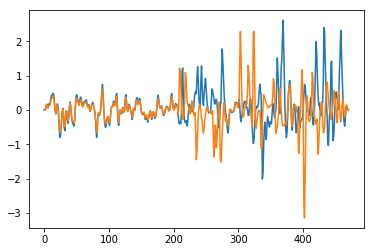

In [81]:
# plt.plot(ppis['single'])
plt.plot(ppis['repeat_ppi'])
plt.plot(ppis['switch_ppi'])

In [91]:
frame_times = np.linspace(0, len(test_ts[:,0])*2, num=len(test_ts[:,0]), endpoint=False)
ppi_design = make_first_level_design_matrix(frame_times, events_df, hrf_model='spm',
                               drift_model=None, add_regs=np.array(list(ppis.values())).T, add_reg_names=ppis.keys())

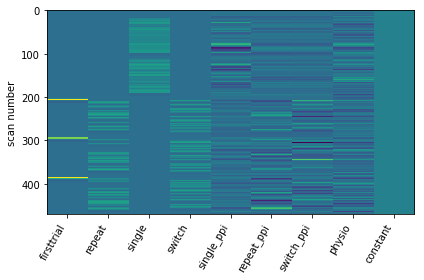

In [130]:
plot_design_matrix(ppi_design)

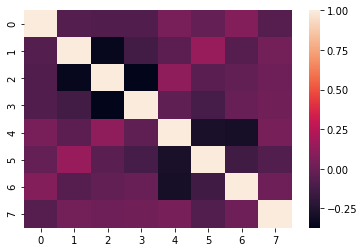

In [145]:
sns.heatmap(np.corrcoef(ppi_design.iloc[:,:-1].T))

In [135]:
np.corrcoef(ppi_design[:])

array([], shape=(0, 0), dtype=float64)

In [105]:
test_img = nib.Nifti1Image(np.array([[test_ts.T]]), np.eye(4))
mask_img = nib.Nifti1Image(np.ones(test_img.shape[:-1]), np.eye(4))
flm = FirstLevelModel(t_r=2, hrf_model='spm', mask_img=mask_img, drift_model=None)

In [106]:
# question: should I weigh the events by how many events there are?
flm.fit(test_img, design_matrices=ppi_design)

FirstLevelModel(drift_model=None, drift_order=1, fir_delays=[0],
        high_pass=0.01, hrf_model='spm',
        mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f316ef6cf50>,
        memory=Memory(cachedir=None), memory_level=1, min_onset=-24,
        minimize_memory=True, n_jobs=1, noise_model='ar1',
        signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=None,
        standardize=False, subject_label=None, t_r=2, target_affine=None,
        target_shape=None, verbose=0)

In [117]:
z_switch_repeat_ppi = flm.compute_contrast('switch_ppi - repeat_ppi', output_type='z_score')
z_switch_single_ppi = flm.compute_contrast('switch_ppi - single_ppi', output_type='z_score')
z_repeat_single_ppi = flm.compute_contrast('repeat_ppi - single_ppi', output_type='z_score')

In [124]:
z_switch_single_ppi.get_fdata()

array([[[-1.4794946 , -1.94854191,  0.77528443, -1.31531054,
          1.96776021, -0.68637639, -0.91158879, -0.05442986,
          1.8352428 ,  1.93913669,  0.90042324, -0.99348474,
         -0.99948107, -1.50152783, -0.94705411,  0.58041998,
         -1.24423076,  0.05302252,  0.05430287, -1.482733  ,
         -1.46676601]]])

In [125]:
z_repeat_single_ppi.get_fdata()

array([[[-1.98578094, -0.8945904 ,  1.00988302, -1.06436435,
         -0.31166923, -2.40646695, -0.75091646, -0.67461311,
          0.97597121,  2.05399804,  1.20366863, -1.51846806,
          0.22832221, -0.2225741 , -0.99169099,  1.44235178,
         -1.29636408,  0.40229381,  0.37828437, -1.10132029,
         -2.27336045]]])

In [176]:
switch_repeat_matrix = np.zeros((test_ts.shape[1], test_ts.shape[1]))
switch_single_matrix = np.zeros((test_ts.shape[1], test_ts.shape[1]))
repeat_single_matrix = np.zeros((test_ts.shape[1], test_ts.shape[1]))
for idx, ts in enumerate(test_ts.T):
    ppis = {tt+"_ppi": create_ppi(ts, 2, events_df, tt) for tt in ['single', 'repeat', 'switch']}
    ppis['physio'] = ts
    
    ppi_design = make_first_level_design_matrix(frame_times, events_df, hrf_model='spm',
                                                drift_model=None, add_regs=np.array(list(ppis.values())).T,
                                                add_reg_names=ppis.keys())
    flm.fit(test_img, design_matrices=ppi_design)

    switch_repeat_matrix[:,idx] = flm.compute_contrast('switch - repeat', output_type='z_score').get_fdata().squeeze()
    switch_single_matrix[:,idx] = flm.compute_contrast('switch - single', output_type='z_score').get_fdata().squeeze()
    repeat_single_matrix[:,idx] = flm.compute_contrast('repeat - single', output_type='z_score').get_fdata().squeeze()
    


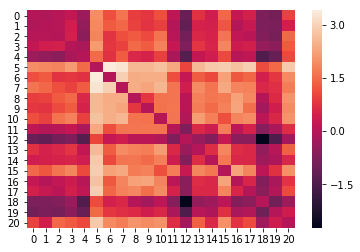

In [179]:
switch_repeat_matrix_sym = (switch_repeat_matrix + switch_repeat_matrix.T) / 2
np.fill_diagonal(switch_repeat_matrix_sym, 0)
sns.heatmap(switch_repeat_matrix_sym)

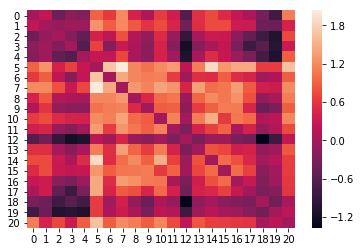

In [180]:
switch_single_matrix_sym = (switch_single_matrix + switch_single_matrix.T) / 2
np.fill_diagonal(switch_single_matrix_sym, 0)
sns.heatmap(switch_single_matrix_sym)

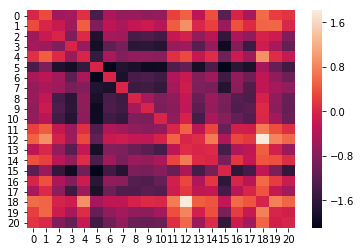

In [181]:
repeat_single_matrix_sym = (repeat_single_matrix + repeat_single_matrix.T) / 2
np.fill_diagonal(repeat_single_matrix_sym, np.nan)
sns.heatmap(repeat_single_matrix_sym)

In [ ]:
events_df.to_csv()

## PPI Task Switch Activation Atlas

In [20]:
outdir = os.path.join(os.getcwd(), 'ppiMatrices')
participants = layout.get_subjects()
masker = NiftiLabelsMasker(ATLAS_PATH)
confounds = [
    "white_matter",
    "csf",
    "cosine[0-9]{2}",
    "framewise_displacement",
    "non_steady_state_outlier[0-9]{2}",
    "motion_outlier[0-9]{2}"
]
task = 'taskswitch'
columns = pd.read_csv(ATLAS_LUT, sep='\t')['regions']
for participant in participants:
    # make output directory for participant
    participant_outdir = os.path.join(outdir, 'sub-' + participant)
    os.makedirs(participant_outdir, exist_ok=True)

    preproc = layout.get(subject=participant,
                 suffix='bold',
                 extension='nii.gz',
                 desc='preproc',
                 space='MNI152NLin2009cAsym',
                 task=task)[0]

    confounds_file = layout.get(subject=participant,
                                suffix='regressors',
                                extension='tsv',
                                desc='confounds',
                                task=task,
                                return_type='file')[0]

    event_file = layout.get(subject=participant,
                                suffix='events',
                                extension='tsv',
                                task=task,
                                return_type='file')[0]
    
    confounds_df = _select_confounds(confounds_file, confounds)
    roi_timeseries = masker.fit_transform(preproc.path, confounds=confounds_df.values)
    
    events_df = pd.read_csv(event_file, sep='\t')
    
    tr = preproc.get_metadata()['RepetitionTime']
    
    roi_img = nib.Nifti1Image(np.array([[roi_timeseries.T]]), np.eye(4))
    mask_img = nib.Nifti1Image(np.ones(roi_img.shape[:-1]), np.eye(4))
    
    flm = FirstLevelModel(t_r=2, hrf_model='spm', mask_img=mask_img, drift_model=None)
    
    contrast_matrices = {
        "switchxrepeat": np.zeros((roi_timeseries.shape[1], roi_timeseries.shape[1])),
        "switchxsingle": np.zeros((roi_timeseries.shape[1], roi_timeseries.shape[1])),
        "repeatxsingle": np.zeros((roi_timeseries.shape[1], roi_timeseries.shape[1]))
    }

    frame_times = np.linspace(0, len(roi_timeseries[:,0]) * tr, num=len(roi_timeseries[:,0]), endpoint=False)
    for idx, ts in enumerate(roi_timeseries.T):
        ppis = {tt+"_ppi": create_ppi(ts, 2, events_df, tt) for tt in ['single', 'repeat', 'switch']}
        ppis['physio'] = ts

        ppi_design = make_first_level_design_matrix(frame_times, events_df, hrf_model='spm',
                                                    drift_model=None, add_regs=np.array(list(ppis.values())).T,
                                                    add_reg_names=ppis.keys())
        flm.fit(roi_img, design_matrices=ppi_design)

        contrast_matrices["switchxrepeat"][:,idx] = flm.compute_contrast('switch_ppi - repeat_ppi', output_type='z_score').get_fdata().squeeze()
        contrast_matrices["switchxsingle"][:,idx] = flm.compute_contrast('switch_ppi - single_ppi', output_type='z_score').get_fdata().squeeze()
        contrast_matrices["repeatxsingle"][:,idx] = flm.compute_contrast('repeat_ppi - single_ppi', output_type='z_score').get_fdata().squeeze()
    
    for contrast, matrix in contrast_matrices.items():
        matrix_sym = (matrix + matrix.T) / 2
        np.fill_diagonal(matrix_sym, np.nan)
        matrix_df = pd.DataFrame(matrix_sym, index=columns, columns=columns)
        out_file = os.path.join(participant_outdir, 'sub-' + participant + '_task-' + task + '_desc-' + contrast + '_matrix.tsv')
        matrix_df.to_csv(out_file, sep='\t', na_rep='n/a')

## PPI Fauxbold Activation Atlas

In [21]:
outdir = os.path.join(os.getcwd(), 'ppiMatrices')
participants = layout.get_subjects()
masker = NiftiLabelsMasker(ATLAS_PATH)
confounds = [
    "white_matter",
    "csf",
    "cosine[0-9]{2}",
    "framewise_displacement",
    "non_steady_state_outlier[0-9]{2}",
    "motion_outlier[0-9]{2}"
]
task = 'fauxbold'
columns = pd.read_csv(ATLAS_LUT, sep='\t')['regions']
for participant in participants:
    # make output directory for participant
    participant_outdir = os.path.join(outdir, 'sub-' + participant)
    os.makedirs(participant_outdir, exist_ok=True)

    preproc = layout.get(subject=participant,
                 suffix='bold',
                 extension='nii.gz',
                 desc='preproc',
                 space='MNI152NLin2009cAsym',
                 task=task)[0]

    confounds_file = layout.get(subject=participant,
                                suffix='regressors',
                                extension='tsv',
                                desc='confounds',
                                task=task,
                                return_type='file')[0]

    event_file = layout.get(subject=participant,
                                suffix='events',
                                extension='tsv',
                                task=task,
                                return_type='file')[0]
    
    confounds_df = _select_confounds(confounds_file, confounds)
    roi_timeseries = masker.fit_transform(preproc.path, confounds=confounds_df.values)
    
    events_df = pd.read_csv(event_file, sep='\t')
    
    tr = preproc.get_metadata()['RepetitionTime']
    
    roi_img = nib.Nifti1Image(np.array([[roi_timeseries.T]]), np.eye(4))
    mask_img = nib.Nifti1Image(np.ones(roi_img.shape[:-1]), np.eye(4))
    
    flm = FirstLevelModel(t_r=2, hrf_model='spm', mask_img=mask_img, drift_model=None)
    
    contrast_matrices = {
        "switchxrepeat": np.zeros((roi_timeseries.shape[1], roi_timeseries.shape[1])),
        "switchxsingle": np.zeros((roi_timeseries.shape[1], roi_timeseries.shape[1])),
        "repeatxsingle": np.zeros((roi_timeseries.shape[1], roi_timeseries.shape[1]))
    }

    frame_times = np.linspace(0, len(roi_timeseries[:,0]) * tr, num=len(roi_timeseries[:,0]), endpoint=False)
    for idx, ts in enumerate(roi_timeseries.T):
        ppis = {tt+"_ppi": create_ppi(ts, 2, events_df, tt) for tt in ['single', 'repeat', 'switch']}
        ppis['physio'] = ts

        ppi_design = make_first_level_design_matrix(frame_times, events_df, hrf_model='spm',
                                                    drift_model=None, add_regs=np.array(list(ppis.values())).T,
                                                    add_reg_names=ppis.keys())
        flm.fit(roi_img, design_matrices=ppi_design)

        contrast_matrices["switchxrepeat"][:,idx] = flm.compute_contrast('switch_ppi - repeat_ppi', output_type='z_score').get_fdata().squeeze()
        contrast_matrices["switchxsingle"][:,idx] = flm.compute_contrast('switch_ppi - single_ppi', output_type='z_score').get_fdata().squeeze()
        contrast_matrices["repeatxsingle"][:,idx] = flm.compute_contrast('repeat_ppi - single_ppi', output_type='z_score').get_fdata().squeeze()
    
    for contrast, matrix in contrast_matrices.items():
        matrix_sym = (matrix + matrix.T) / 2
        np.fill_diagonal(matrix_sym, np.nan)
        matrix_df = pd.DataFrame(matrix_sym, index=columns, columns=columns)
        out_file = os.path.join(participant_outdir, 'sub-' + participant + '_task-' + task + '_desc-' + contrast + '_matrix.tsv')
        matrix_df.to_csv(out_file, sep='\t', na_rep='n/a')

## PPI Task Switch Schaefer Atlas

In [12]:
outdir = os.path.join(os.getcwd(), 'ppiMatricesSchaefer')
participants = layout.get_subjects()
masker = NiftiLabelsMasker(SCHAEFER_PATH)
confounds = [
    "white_matter",
    "csf",
    "cosine[0-9]{2}",
    "framewise_displacement",
    "non_steady_state_outlier[0-9]{2}",
    "motion_outlier[0-9]{2}"
]
task = 'taskswitch'
columns = pd.read_csv(SCHAEFER_LUT, sep='\t')['regions']
for participant in participants:
    # make output directory for participant
    participant_outdir = os.path.join(outdir, 'sub-' + participant)
    os.makedirs(participant_outdir, exist_ok=True)

    # check if participant needs to be run
    contrasts = ["switchxrepeat", "switchxsingle", "repeatxsingle"]
    file_count = 0
    for contrast in contrasts:
        out_file = os.path.join(participant_outdir, 'sub-' + participant + '_task-' + task + '_desc-' + contrast + '_matrix.tsv')
        if os.path.exists(out_file):
            file_count += 1
    if file_count == len(contrasts):
        continue

    preproc = layout.get(subject=participant,
                 suffix='bold',
                 extension='nii.gz',
                 desc='preproc',
                 space='MNI152NLin2009cAsym',
                 task=task)[0]

    confounds_file = layout.get(subject=participant,
                                suffix='regressors',
                                extension='tsv',
                                desc='confounds',
                                task=task,
                                return_type='file')[0]

    event_file = layout.get(subject=participant,
                                suffix='events',
                                extension='tsv',
                                task=task,
                                return_type='file')[0]
    
    confounds_df = _select_confounds(confounds_file, confounds)
    roi_timeseries = masker.fit_transform(preproc.path, confounds=confounds_df.values)
    
    events_df = pd.read_csv(event_file, sep='\t')
    
    tr = preproc.get_metadata()['RepetitionTime']
    
    roi_img = nib.Nifti1Image(np.array([[roi_timeseries.T]]), np.eye(4))
    mask_img = nib.Nifti1Image(np.ones(roi_img.shape[:-1]), np.eye(4))
    
    flm = FirstLevelModel(t_r=2, hrf_model='spm', mask_img=mask_img, drift_model=None)
    
    contrast_matrices = {
        contrast: np.zeros((roi_timeseries.shape[1], roi_timeseries.shape[1]))
        for contrast in contrasts
    }

    frame_times = np.linspace(0, len(roi_timeseries[:,0]) * tr, num=len(roi_timeseries[:,0]), endpoint=False)
    for idx, ts in enumerate(roi_timeseries.T):
        ppis = {tt+"_ppi": create_ppi(ts, 2, events_df, tt) for tt in ['single', 'repeat', 'switch']}
        ppis['physio'] = ts

        ppi_design = make_first_level_design_matrix(frame_times, events_df, hrf_model='spm',
                                                    drift_model=None, add_regs=np.array(list(ppis.values())).T,
                                                    add_reg_names=ppis.keys())
        flm.fit(roi_img, design_matrices=ppi_design)

        contrast_matrices["switchxrepeat"][:,idx] = flm.compute_contrast('switch_ppi - repeat_ppi', output_type='z_score').get_fdata().squeeze()
        contrast_matrices["switchxsingle"][:,idx] = flm.compute_contrast('switch_ppi - single_ppi', output_type='z_score').get_fdata().squeeze()
        contrast_matrices["repeatxsingle"][:,idx] = flm.compute_contrast('repeat_ppi - single_ppi', output_type='z_score').get_fdata().squeeze()
    
    for contrast, matrix in contrast_matrices.items():
        matrix_sym = (matrix + matrix.T) / 2
        np.fill_diagonal(matrix_sym, np.nan)
        matrix_df = pd.DataFrame(matrix_sym, index=columns, columns=columns)
        out_file = os.path.join(participant_outdir, 'sub-' + participant + '_task-' + task + '_desc-' + contrast + '_matrix.tsv')
        matrix_df.to_csv(out_file, sep='\t', na_rep='n/a')

## PPI Fauxbold Schaefer Atlas

In [17]:
outdir = os.path.join(os.getcwd(), 'ppiMatricesSchaefer')
participants = layout.get_subjects()
masker = NiftiLabelsMasker(SCHAEFER_PATH)
confounds = [
    "white_matter",
    "csf",
    "cosine[0-9]{2}",
    "framewise_displacement",
    "non_steady_state_outlier[0-9]{2}",
    "motion_outlier[0-9]{2}"
]
task = 'fauxbold'
columns = pd.read_csv(SCHAEFER_LUT, sep='\t')['regions']
for participant in participants:
    # make output directory for participant
    participant_outdir = os.path.join(outdir, 'sub-' + participant)
    os.makedirs(participant_outdir, exist_ok=True)

    # check if participant needs to be run
    contrasts = ["switchxrepeat", "switchxsingle", "repeatxsingle"]
    file_count = 0
    for contrast in contrasts:
        out_file = os.path.join(participant_outdir, 'sub-' + participant + '_task-' + task + '_desc-' + contrast + '_matrix.tsv')
        if os.path.exists(out_file):
            file_count += 1
    if file_count == len(contrasts):
        print("skipping:", participant)
        continue

    # make output directory for participant
    participant_outdir = os.path.join(outdir, 'sub-' + participant)
    os.makedirs(participant_outdir, exist_ok=True)

    preproc = layout.get(subject=participant,
                 suffix='bold',
                 extension='nii.gz',
                 desc='preproc',
                 space='MNI152NLin2009cAsym',
                 task=task)[0]

    confounds_file = layout.get(subject=participant,
                                suffix='regressors',
                                extension='tsv',
                                desc='confounds',
                                task=task,
                                return_type='file')[0]

    event_file = layout.get(subject=participant,
                                suffix='events',
                                extension='tsv',
                                task=task,
                                return_type='file')[0]
    
    confounds_df = _select_confounds(confounds_file, confounds)
    roi_timeseries = masker.fit_transform(preproc.path, confounds=confounds_df.values)
    
    events_df = pd.read_csv(event_file, sep='\t')
    
    tr = preproc.get_metadata()['RepetitionTime']
    
    roi_img = nib.Nifti1Image(np.array([[roi_timeseries.T]]), np.eye(4))
    mask_img = nib.Nifti1Image(np.ones(roi_img.shape[:-1]), np.eye(4))
    
    flm = FirstLevelModel(t_r=2, hrf_model='spm', mask_img=mask_img, drift_model=None)
    
    contrast_matrices = {
        contrast: np.zeros((roi_timeseries.shape[1], roi_timeseries.shape[1]))
        for contrast in contrasts
    }

    frame_times = np.linspace(0, len(roi_timeseries[:,0]) * tr, num=len(roi_timeseries[:,0]), endpoint=False)
    for idx, ts in enumerate(roi_timeseries.T):
        ppis = {tt+"_ppi": create_ppi(ts, 2, events_df, tt) for tt in ['single', 'repeat', 'switch']}
        ppis['physio'] = ts

        ppi_design = make_first_level_design_matrix(frame_times, events_df, hrf_model='spm',
                                                    drift_model=None, add_regs=np.array(list(ppis.values())).T,
                                                    add_reg_names=ppis.keys())
        flm.fit(roi_img, design_matrices=ppi_design)

        contrast_matrices["switchxrepeat"][:,idx] = flm.compute_contrast('switch_ppi - repeat_ppi', output_type='z_score').get_fdata().squeeze()
        contrast_matrices["switchxsingle"][:,idx] = flm.compute_contrast('switch_ppi - single_ppi', output_type='z_score').get_fdata().squeeze()
        contrast_matrices["repeatxsingle"][:,idx] = flm.compute_contrast('repeat_ppi - single_ppi', output_type='z_score').get_fdata().squeeze()
    
    for contrast, matrix in contrast_matrices.items():
        matrix_sym = (matrix + matrix.T) / 2
        np.fill_diagonal(matrix_sym, np.nan)
        matrix_df = pd.DataFrame(matrix_sym, index=columns, columns=columns)
        out_file = os.path.join(participant_outdir, 'sub-' + participant + '_task-' + task + '_desc-' + contrast + '_matrix.tsv')
        matrix_df.to_csv(out_file, sep='\t', na_rep='n/a')

skipping: GE120001
skipping: GE120002
skipping: GE120003
skipping: GE120004
skipping: GE120005
skipping: GE120006
skipping: GE120008
skipping: GE120010
skipping: GE120011
skipping: GE120012
skipping: GE120013
skipping: GE120014
skipping: GE120015
skipping: GE120017
skipping: GE120018
skipping: GE120019
skipping: GE120020
skipping: GE120021
skipping: GE120023
skipping: GE120024
skipping: GE120025
skipping: GE120026
skipping: GE120027
skipping: GE120028
skipping: GE120029
skipping: GE120030
skipping: GE120031
skipping: GE120032
skipping: GE120033
skipping: GE120034
skipping: GE120035
skipping: GE120036
skipping: GE120037
skipping: GE120038
skipping: GE120039
skipping: GE120040
skipping: GE120041
skipping: GE120042
skipping: GE120043
skipping: GE120044
skipping: GE120045
skipping: GE120047
skipping: GE120049
skipping: GE120050
skipping: GE120052
skipping: GE120053
skipping: GE120054
skipping: GE120055
skipping: GE120056
skipping: GE120057
skipping: GE120058
skipping: GE120059
skipping: GE